In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import scipy.io as sc
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2024-05-19 23:57:28.831718: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:57:28.838061: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:57:28.899279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 23:57:31.156116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = np.load('data.npy')
label = np.load('labels.npy')
label_number = np.zeros(label.shape)

In [3]:
label_names = np.unique(label)

In [4]:
X = data.reshape([data.shape[0],-1])
Y = label_names.reshape([-1,1])

In [5]:
for i in range(len(label_names)):
    label_number[label == label_names[i]] = i

In [6]:
Y = label_number.reshape([-1,1])

In [7]:
MAX = X.max()
MIN = X.min()
X_NORMALIZED = (X - MIN) / (MAX - MIN)

In [8]:
# Convert integer labels to one-hot encoded labels
num_actions = len(np.unique(Y))
Y_one_hot = to_categorical(Y-1, num_classes=num_actions)

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_NORMALIZED, Y_one_hot, test_size=0.2, random_state=42, shuffle=True)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (3680, 1024)
X_test shape: (920, 1024)
Y_train shape: (3680, 10)
Y_test shape: (920, 10)


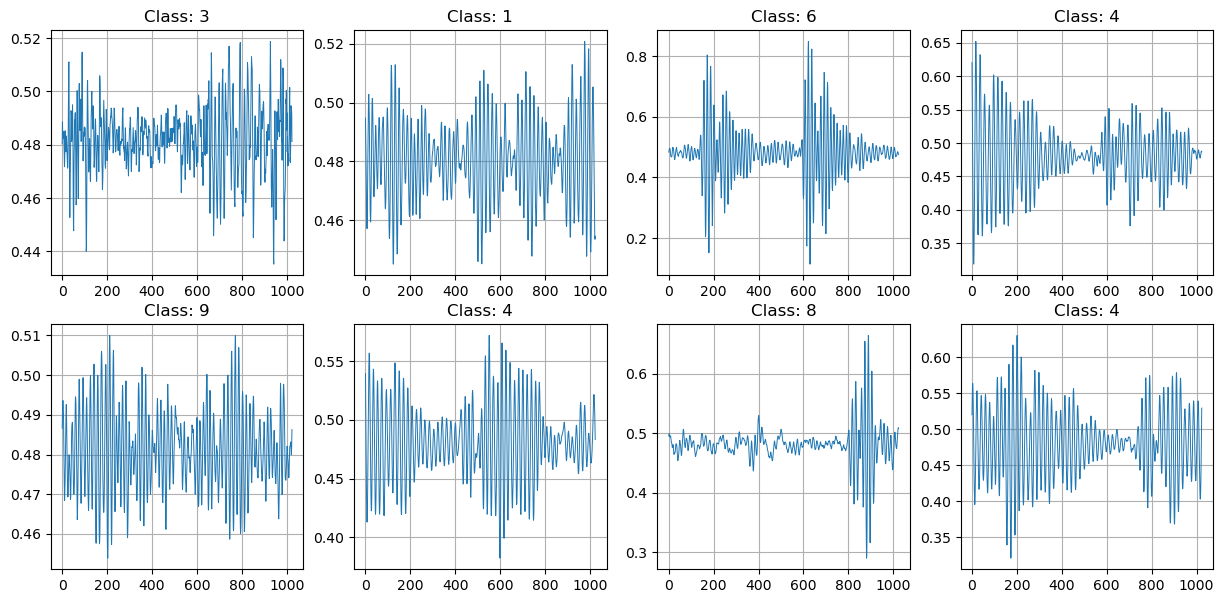

In [9]:
plt.figure(figsize=(15,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.plot(X_train[i], linewidth=0.7)
    plt.title(f"Class: {np.argmax(Y_train[i])}")
    plt.grid()
plt.show()

In [10]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes = 10, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2]:#, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out
    

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1024,)))
model.add(tf.keras.layers.Reshape((32, 32, 1)))
model.add(ResNet18(10))
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()


/home/mohadese/miniconda3/envs/CI/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-05-19 23:57:36.371430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 23:57:36.372860: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mohadese/miniconda3/envs/CI/lib/python3.12/site-packages/keras/src/layer

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net18 (ResNet18)            │ (None, 10)             │       152,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,842 (597.04 KB)

 Trainable params: 152,202 (594.54 KB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
from keras.saving import load_model

# model.save('resnet_model.keras')

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'resnet_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


hist = model.fit(X_train, Y_train, epochs=700, batch_size=256, validation_data=(X_test, Y_test), callbacks=[model_checkpoint_callback])

Epoch 1/700


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2741 - loss: 2.0447
Epoch 1: val_accuracy improved from -inf to 0.09130, saving model to resnet_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.2810 - loss: 2.0264 - val_accuracy: 0.0913 - val_loss: 15.0631
Epoch 2/700
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6158 - loss: 1.1737
Epoch 2: val_accuracy did not improve from 0.09130
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.6185 - loss: 1.1679 - val_accuracy: 0.0913 - val_loss: 9.9521
Epoch 3/700
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7706 - loss: 0.7615
Epoch 3: val_accuracy did not improve from 0.09130
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - accuracy: 0.7719 - loss: 0.7569 - val_accuracy: 0.0913 - val_loss: 7.6166
Epoch 4/700
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8233 - loss: 0.5186
Epoch 4: val_accuracy did not improve from 0.09130
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.8238 - loss: 0.

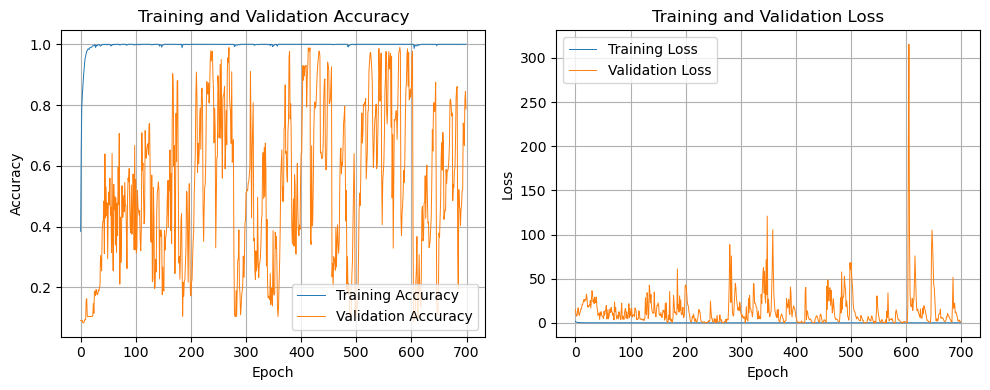

In [13]:
# Plot the training history
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Get training and validation loss values from the history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, linewidth=0.7, label='Training Accuracy')
plt.plot(val_accuracy, linewidth=0.7, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, linewidth=0.7, label='Training Loss')
plt.plot(val_loss, linewidth=0.7, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [14]:
# model.save("model.h5")

/home/mohadese/miniconda3/envs/CI/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'res_net18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7933 - loss: 1.6596
Test Loss: 1.6791496276855469
Test Accuracy: 0.7869565486907959
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


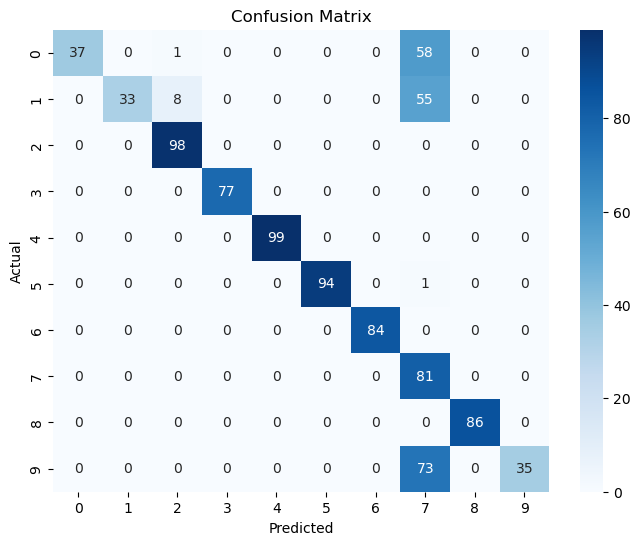

In [15]:
from tensorflow.keras.utils import custom_object_scope
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Register the custom layer
with custom_object_scope({'ResNet18': ResNet18}):
    # Load the model
    loaded_model = load_model('model.h5')

# Evaluate the model on the test data
evaluation = model.evaluate(X_test, Y_test)

# Print the evaluation metrics (e.g., loss and accuracy)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Predict on the test set
Y_pred = model.predict(X_test)

# Create a confusion matrix
Y_test_CLASS = np.argmax(Y_test, axis=1)    
Y_pred_CLASS = np.argmax(Y_pred, axis=1)    

conf_matrix = confusion_matrix(Y_test_CLASS, Y_pred_CLASS)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
